# LLM Inference
## Featuring: Falcon-7B-Instruct on Lightning-GPT
Adapted from this repository: https://github.com/Phillips-Lab-MTSU/llm-finetuning

The first parts of the notebook can be run using the Bash kernel, but it would be best to instead open a terminal on the side and copy-paste the command blocks into the terminal. Be sure to use the button in the upper right of the notebook panel to switch between "Bash" and "Python 3 (ipykernel)" when needed.

### Install `lit-gpt` prerequisites

In [1]:
pip install jsonargparse[signatures] sentencepiece bitsandbytes==0.41.0
MAX_JOBS=8 pip install flash-attn --no-build-isolation

### Grab the repo for `lit-gpt`

In [2]:
git clone https://github.com/Lightning-AI/lit-gpt.git
cd lit-gpt && git checkout 6178c7cc58ba82e5cce138e7a3159c384e2d3b0f && cd ..

fatal: destination path 'lit-gpt' already exists and is not an empty directory.
HEAD is now at 6178c7c Half precision fixes (#606)


### Download Falcon-7B-Instruct

Note this will take quite a while and produce a lot of output if you run it in the notebook. I recommend running it outside of the notebook environment. Good news is that the 

In [ ]:
python lit-gpt/scripts/download.py \
    --repo_id tiiuae/falcon-7b-instruct

In [5]:
python lit-gpt/scripts/convert_hf_checkpoint.py \
    --checkpoint_dir checkpoints/tiiuae/falcon-7b-instruct

Model config {'org': 'tiiuae', 'name': 'falcon-7b-instruct', 'block_size': 2048, 'vocab_size': 65024, 'padding_multiple': 512, 'padded_vocab_size': 65024, 'n_layer': 32, 'n_head': 71, 'n_embd': 4544, 'rotary_percentage': 1.0, 'parallel_residual': True, 'bias': False, 'lm_head_bias': False, 'n_query_groups': 1, 'shared_attention_norm': True, '_norm_class': 'LayerNorm', 'norm_eps': 1e-05, '_mlp_class': 'GptNeoxMLP', 'gelu_approximate': 'none', 'intermediate_size': 18176, 'rope_condense_ratio': 1, 'rope_base': 10000}
Processing checkpoints/tiiuae/falcon-7b-instruct/pytorch_model-00001-of-00002.bin
Loading 'transformer.word_embeddings.weight' into RAM
Loading 'transformer.h.0.input_layernorm.weight' into RAM
Loading 'transformer.h.0.input_layernorm.bias' into RAM
Loading 'transformer.h.0.self_attention.query_key_value.weight' into RAM
Loading 'transformer.h.0.self_attention.dense.weight' into RAM
Loading 'transformer.h.0.mlp.dense_h_to_4h.weight' into RAM
Loading 'transformer.h.0.mlp.dense

### Check Inference with a Prompt

In [6]:
python lit-gpt/generate/base.py \
    --checkpoint_dir checkpoints/tiiuae/falcon-7b-instruct \
    --prompt "Tell me an interesting fun fact about earth:"

Loading model 'checkpoints/tiiuae/falcon-7b-instruct/lit_model.pth' with {'org': 'tiiuae', 'name': 'falcon-7b-instruct', 'block_size': 2048, 'vocab_size': 65024, 'padding_multiple': 512, 'padded_vocab_size': 65024, 'n_layer': 32, 'n_head': 71, 'n_embd': 4544, 'rotary_percentage': 1.0, 'parallel_residual': True, 'bias': False, 'lm_head_bias': False, 'n_query_groups': 1, 'shared_attention_norm': True, '_norm_class': 'LayerNorm', 'norm_eps': 1e-05, '_mlp_class': 'GptNeoxMLP', 'gelu_approximate': 'none', 'intermediate_size': 18176, 'rope_condense_ratio': 1, 'rope_base': 10000, 'head_size': 64, 'rope_n_elem': 64}
Time to instantiate model: 0.04 seconds.
Time to load the model weights: 13.94 seconds.
Seed set to 1234
Tell me an interesting fun fact about earth:
Earth has the longest day of the year on June 21, which means the sun rises around 4:20 AM and sets around 8:40 PM in many parts of the world.Asteroids have been known to have been
Time for inference 1: 254.34 sec total, 0.20 tokens/s

## Switch to Python Now!

We can run the rest of the notebook under the Python3 kernel instead of Bash.

### Customize the Inference Process

In [9]:
import sys
import time
from pathlib import Path
from typing import Literal, Optional

import lightning as L
import torch
from lightning.fabric.plugins import BitsandbytesPrecision
from lightning.fabric.strategies import FSDPStrategy

# Add path for usage without installation...
sys.path.append('lit-gpt')

#from importlib import import_module
#lit_gpt = import_module('lit-gpt')
from lit_gpt import GPT, Config, Tokenizer
from lit_gpt.model import Block
from lit_gpt.utils import (
    check_valid_checkpoint_dir,
    get_default_supported_precision,
    gptq_quantization,
    load_checkpoint,
)

In [10]:
@torch.inference_mode()
def generate(
    model: GPT,
    idx: torch.Tensor,
    max_returned_tokens: int,
    *,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    eos_id: Optional[int] = None,
) -> torch.Tensor:
    """Takes a conditioning sequence (prompt) as input and continues to generate as many tokens as requested.

    The implementation of this function is modified from A. Karpathy's nanoGPT.

    Args:
        model: The model to use.
        idx: Tensor of shape (T) with indices of the prompt sequence.
        max_returned_tokens: The maximum number of tokens to return (given plus generated).
        temperature: Scales the predicted logits by 1 / temperature.
        top_k: If specified, only sample among the tokens with the k highest probabilities.
        eos_id: If specified, stop generating any more token once the <eos> token is triggered.
    """
    T = idx.size(0)
    assert max_returned_tokens > T
    if model.max_seq_length < max_returned_tokens - 1:
        # rolling the kv cache based on the `input_pos` value would be necessary. However, doing so would introduce a
        # data dependency on the `input_pos` tensor and impact model compilation. Since this setting is uncommon, we do
        # not support it to avoid negatively impacting the overall speed
        raise NotImplementedError(f"max_seq_length {model.max_seq_length} needs to be >= {max_returned_tokens - 1}")

    device, dtype = idx.device, idx.dtype
    # create an empty tensor of the expected final shape and fill in the current tokens
    empty = torch.empty(max_returned_tokens, dtype=dtype, device=device)
    empty[:T] = idx
    idx = empty
    input_pos = torch.arange(0, T, device=device)

    # generate up to a fixed number of tokens
    for _ in range(max_returned_tokens - T):
        x = idx.index_select(0, input_pos).view(1, -1)

        # forward
        logits = model(x, input_pos)
        logits = logits[0, -1] / temperature

        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits = torch.where(logits < v[[-1]], -float("Inf"), logits)

        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).to(dtype=dtype)

        # advance
        input_pos = input_pos[-1:] + 1

        # concatenate the new generation
        idx = idx.index_copy(0, input_pos, idx_next)

        # if <eos> token is triggered, return the output (stop generation)
        if idx_next == eos_id:
            return idx[:input_pos]  # include the EOS token

    return idx

In [22]:
prompt = "Hello, my name is"
seed = 0
num_samples = 1
max_new_tokens = 100
top_k = 200
temperature = 0.8
checkpoint_dir = Path("checkpoints/tiiuae/falcon-7b-instruct")
quantize = None
strategy = "auto"
devices = 1
precision = None
torch.set_float32_matmul_precision("high")

In [24]:
precision = precision or get_default_supported_precision(training=False)

plugins = None
if quantize is not None:
    if devices > 1:
        raise NotImplementedError(
            "Quantization is currently not supported for multi-GPU training. Please set devices=1 when using the"
            " --quantize flag."
        )
    if quantize.startswith("bnb."):
        if "mixed" in precision:
            raise ValueError("Quantization and mixed precision is not supported.")
        dtype = {"16-true": torch.float16, "bf16-true": torch.bfloat16, "32-true": torch.float32}[precision]
        plugins = BitsandbytesPrecision(quantize[4:], dtype)
        precision = None

if strategy == "fsdp":
    strategy = FSDPStrategy(auto_wrap_policy={Block}, cpu_offload=False)

fabric = L.Fabric(devices=devices, precision=precision, strategy=strategy, plugins=plugins)
fabric.launch()

check_valid_checkpoint_dir(checkpoint_dir)

config = Config.from_json(checkpoint_dir / "lit_config.json")

if quantize == "gptq.int4":
    model_file = "lit_model_gptq.4bit.pth"
    if not (checkpoint_dir / model_file).is_file():
        raise ValueError("Please run `python quantize/gptq.py` first")
else:
    model_file = "lit_model.pth"
checkpoint_path = checkpoint_dir / model_file

fabric.print(f"Loading model {str(checkpoint_path)!r} with {config.__dict__}", file=sys.stderr)
t0 = time.perf_counter()
with fabric.init_module(empty_init=True), gptq_quantization(quantize == "gptq.int4"):
    model = GPT(config)
fabric.print(f"Time to instantiate model: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)

model.eval()
model = fabric.setup_module(model)

t0 = time.perf_counter()
load_checkpoint(fabric, model, checkpoint_path)
fabric.print(f"Time to load the model weights: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)

tokenizer = Tokenizer(checkpoint_dir)
encoded = tokenizer.encode(prompt, device=fabric.device)
prompt_length = encoded.size(0)
max_returned_tokens = prompt_length + max_new_tokens

with fabric.init_tensor():
    # set the max_seq_length to limit the memory usage to what we need
    model.max_seq_length = max_returned_tokens

L.seed_everything(seed)
for i in range(num_samples):
    with fabric.init_tensor():
        # enable the kv cache
        model.set_kv_cache(batch_size=1)

    t0 = time.perf_counter()
    y = generate(model, encoded, max_returned_tokens, temperature=temperature, top_k=top_k)
    t = time.perf_counter() - t0

    fabric.print(tokenizer.decode(y))
    tokens_generated = y.size(0) - prompt_length
    fabric.print(
        f"Time for inference {i + 1}: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr
    )
if fabric.device.type == "cuda":
    fabric.print(f"Memory used: {torch.cuda.max_memory_allocated() / 1e9:.02f} GB", file=sys.stderr)


Loading model 'checkpoints/tiiuae/falcon-7b-instruct/lit_model.pth' with {'org': 'tiiuae', 'name': 'falcon-7b-instruct', 'block_size': 2048, 'vocab_size': 65024, 'padding_multiple': 512, 'padded_vocab_size': 65024, 'n_layer': 32, 'n_head': 71, 'n_embd': 4544, 'rotary_percentage': 1.0, 'parallel_residual': True, 'bias': False, 'lm_head_bias': False, 'n_query_groups': 1, 'shared_attention_norm': True, '_norm_class': 'LayerNorm', 'norm_eps': 1e-05, '_mlp_class': 'GptNeoxMLP', 'gelu_approximate': 'none', 'intermediate_size': 18176, 'rope_condense_ratio': 1, 'rope_base': 10000, 'head_size': 64, 'rope_n_elem': 64}
Time to instantiate model: 0.02 seconds.
Time to load the model weights: 12.83 seconds.
Seed set to 0


Hello, my name is Lourdes, I'm a Spanish professional translator. I'm here to help you with your translation and writing projects. I can translate, proofread, and rewrite in Spanish, English, French, and German.
I'm a linguist with a degree in English and a Master's in Spanish, and I'm currently working as a professional translator in Spanish and English. My translations are always tailored to your needs, so I can make sure the final product fits your specifications.


Time for inference 1: 454.80 sec total, 0.22 tokens/sec


In [25]:
prompt = "What is one plus one?"
encoded = tokenizer.encode(prompt, device=fabric.device)

In [26]:
for i in range(num_samples):
    with fabric.init_tensor():
        # enable the kv cache
        model.set_kv_cache(batch_size=1)

    t0 = time.perf_counter()
    y = generate(model, encoded, max_returned_tokens, temperature=temperature, top_k=top_k)
    t = time.perf_counter() - t0

    fabric.print(tokenizer.decode(y))
    tokens_generated = y.size(0) - prompt_length
    fabric.print(
        f"Time for inference {i + 1}: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr
    )

What is one plus one?
One plus one is a mathematical operator that returns the result of combining two numbers. It is represented by the symbol "1+1" in programming languages and is commonly used in first-year programming courses.No, "one plus one" isn't a type of number, it's a mathematical operation, like "+" or "x" in the metric system.About the different types of numbers we can use in programmingSee more questions like this...


Time for inference 1: 445.18 sec total, 0.22 tokens/sec


In [27]:
from torchinfo import summary
from torchview import draw_graph

In [28]:
summary(model)

Layer (type:depth-idx)                                  Param #
_FabricModule                                           --
├─GPT: 1-1                                              --
│    └─Linear: 2-1                                      295,469,056
│    └─ModuleDict: 2-2                                  --
│    │    └─Embedding: 3-1                              295,469,056
│    │    └─ModuleList: 3-2                             6,626,242,560
│    │    └─LayerNorm: 3-3                              9,088
├─GPT: 1-2                                              (recursive)
│    └─Linear: 2-3                                      (recursive)
│    └─ModuleDict: 2-4                                  (recursive)
│    │    └─Embedding: 3-4                              (recursive)
│    │    └─ModuleList: 3-5                             (recursive)
│    │    └─LayerNorm: 3-6                              (recursive)
Total params: 7,217,189,760
Trainable params: 7,217,189,760
Non-trainable params: 0

In [ ]:
model_graph = draw_graph(model,input_data=encoded.unsqueeze(0))
model_graph.visual_graph

### Stored copy of the image generated above...

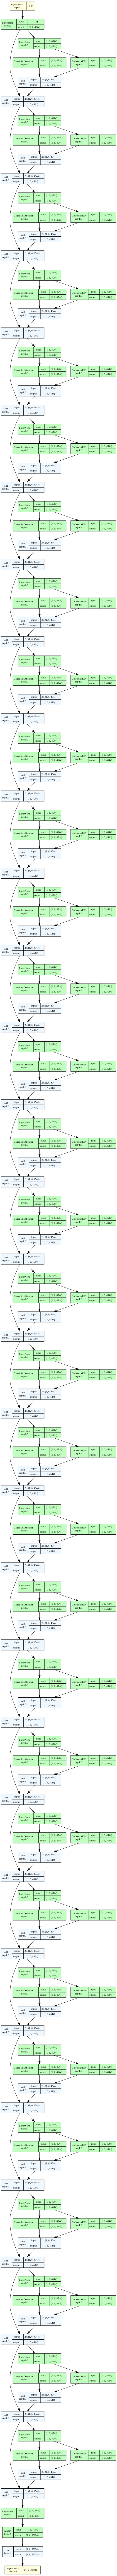